# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
#import required packages and libraries
!pip install haversine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from haversine import haversine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#set style for graph
sns.set_style(style='darkgrid')

# Setting fontsizes,fontweight,label weight for labels,titles.
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.title_fontsize"] = 15

## **Data Preparation**

### **Mounting Drive**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1ndBO1KKbCgiW4XkBdlX5V1dTqswUQtcj/view?usp=sharing'

 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('NYC Taxi Data.csv') 
 
df = pd.read_csv('NYC Taxi Data.csv')

### **Data Inspection**

In [ ]:
#first look checking top 5 rows
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [ ]:
#check information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1458644,1458644,id2875421,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vendor_id,1458644.0,NaN,NaN,NaN,1.53495,0.498777,1.0,1.0,2.0,2.0,2.0
pickup_datetime,1458644,1380222,2016-03-04 08:07:34,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_datetime,1458644,1380377,2016-02-19 19:25:04,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,1458644.0,NaN,NaN,NaN,1.66453,1.314242,0.0,1.0,1.0,2.0,9.0
pickup_longitude,1458644.0,NaN,NaN,NaN,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-61.335529
pickup_latitude,1458644.0,NaN,NaN,NaN,40.750921,0.032881,34.359695,40.737347,40.754101,40.76836,51.881084
dropoff_longitude,1458644.0,NaN,NaN,NaN,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-61.335529
dropoff_latitude,1458644.0,NaN,NaN,NaN,40.7518,0.035891,32.181141,40.735885,40.754524,40.76981,43.921028
store_and_fwd_flag,1458644,2,N,1450599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#check columns names
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
#Check shape of dataset
df.shape 

(1458644, 11)

### **Data Description**

*   id - a unique identifier for each trip
*   vendor_id - a code indicating the provider associated with the trip record
*   pickup_datetime - date and time when the meter was engaged
*   dropoff_datetime - date and time when the meter was disengaged
*   passenger_count - the number of passengers in the vehicle (driver entered value)
*   pickup_longitude - the longitude where the meter was engaged
*   pickup_latitude - the latitude where the meter was engaged
*   dropoff_longitude - the longitude where the meter was disengaged
*   dropoff_latitude - the latitude where the meter was disengaged
*   store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
*   trip_duration - duration of the trip in seconds



In [ ]:
#first create copy of dataset before working with so that we have original data untouched
df1 = df.copy()

### **Check columns and their unique values to understand what they contain.**

In [ ]:
#check unique values for categorical columnns
categorical_columns = df1.select_dtypes(include=['object'])
for col in categorical_columns:
  print(f'Unique values in categorical columns {col} are: {categorical_columns[col].unique()[:8]}\n')

Unique values in categorical columns id are: ['id2875421' 'id2377394' 'id3858529' 'id3504673' 'id2181028' 'id0801584'
 'id1813257' 'id1324603']

Unique values in categorical columns pickup_datetime are: ['2016-03-14 17:24:55' '2016-06-12 00:43:35' '2016-01-19 11:35:24'
 '2016-04-06 19:32:31' '2016-03-26 13:30:55' '2016-01-30 22:01:40'
 '2016-06-17 22:34:59' '2016-05-21 07:54:58']

Unique values in categorical columns dropoff_datetime are: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48'
 '2016-04-06 19:39:40' '2016-03-26 13:38:10' '2016-01-30 22:09:03'
 '2016-06-17 22:40:40' '2016-05-21 08:20:49']

Unique values in categorical columns store_and_fwd_flag are: ['N' 'Y']



In [ ]:
#check unique values for numerical columns
numerical_columns = df1._get_numeric_data()
for col in numerical_columns:
  print(f'Unique values in numerical columns {col} are: {numerical_columns[col].unique()[:8]}\n')

Unique values in numerical columns vendor_id are: [2 1]

Unique values in numerical columns passenger_count are: [1 6 4 2 3 5 0 7]

Unique values in numerical columns pickup_longitude are: [-73.98215485 -73.98041534 -73.97902679 -74.01004028 -73.97305298
 -73.98285675 -73.96901703 -73.96927643]

Unique values in numerical columns pickup_latitude are: [40.76793671 40.73856354 40.7639389  40.7199707  40.79320908 40.74219513
 40.7578392  40.79777908]

Unique values in numerical columns dropoff_longitude are: [-73.96463013 -73.9994812  -74.00533295 -74.01226807 -73.97292328
 -73.99208069 -73.95740509 -73.92247009]

Unique values in numerical columns dropoff_latitude are: [40.76560211 40.73115158 40.71008682 40.70671844 40.78252029 40.74918365
 40.76589584 40.76055908]

Unique values in numerical columns trip_duration are: [ 455  663 2124  429  435  443  341 1551]



In [ ]:
#check count of unqiue id
len(df1['id'].unique())

1458644

In [ ]:
#Convert timestamp to datetime format to fetch the other details as listed below
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [ ]:
#check count of unqiue id
len(df1['id'].unique())

1458644

In [ ]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
df['weekday'] = df.pickup_datetime.dt.weekday
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [ ]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

In [ ]:
#Calculate Speed in km/h for further insights
df['speed'] = (df.distance/(df.trip_duration/3600))

In [ ]:
#Check the type of each variable
df.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [ ]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


Now our dataset is complete for the further analysis before we train our model with optimal variables.

### **Handling missing values.**

In [ ]:
#check null values
df1.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

As we can see there are no null values in our dataset.

In [ ]:
df['id'].value_counts()

id2875421    1
id2249290    1
id2484008    1
id3901436    1
id1265174    1
            ..
id2478352    1
id1159014    1
id3007971    1
id3965191    1
id1209952    1
Name: id, Length: 1458644, dtype: int64

## **EDA**

### **Total Trip per hour**

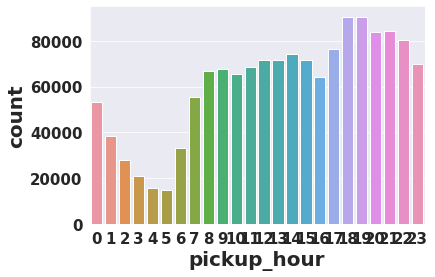

In [ ]:
sns.countplot(df.pickup_hour)
plt.show()

### **Inference**

It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### **Total trips per weekday**

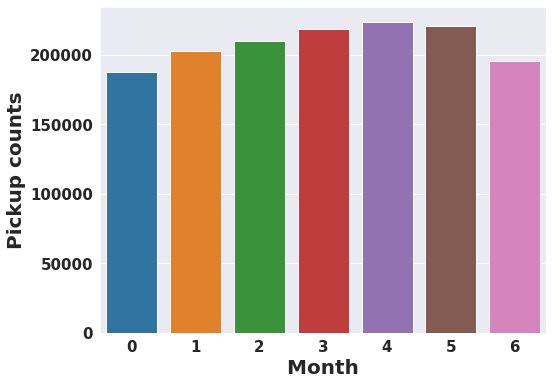

In [ ]:
#Let's take a look now at the distribution of taxi pickups across the week.
plt.figure(figsize = (8,6))
sns.countplot(df.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

### **Observation**

Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

### **Trip Duration per hour**

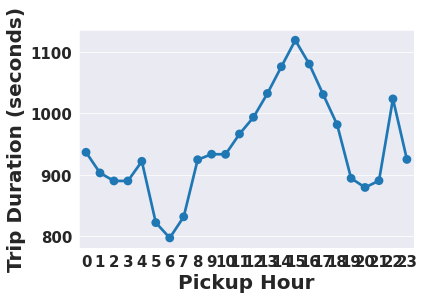

In [ ]:
group1 = df.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

### **Observations**

Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.

Average trip duration is generally highest around 3 PM during the busy streets

Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

### **Trip Duration per weekdays**

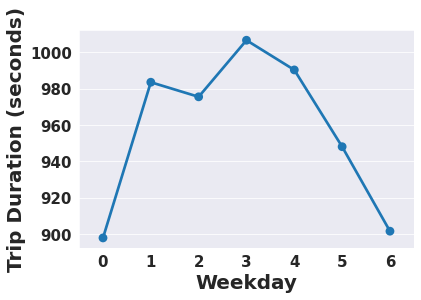

In [ ]:
group2 = df.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

### **Trip duration per month**

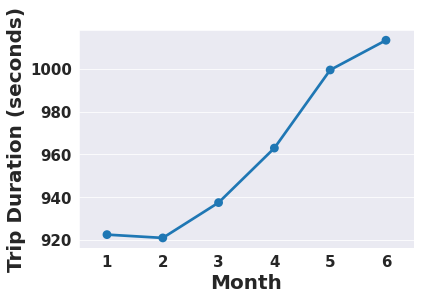

In [ ]:
group3 = df.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### **Observations**

We can see an increasing trend in the average trip duration along with each subsequent month.

The duration difference between each month is not much. It has increased gradually over a period of 6 months.

It is lowest during february when winters starts declining.

There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization.
 As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

### **Trip Duration per vendor**

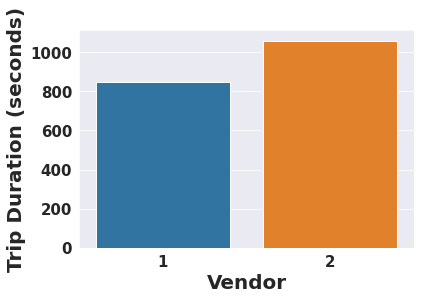

In [ ]:
group4 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

### **Distance per Hour**

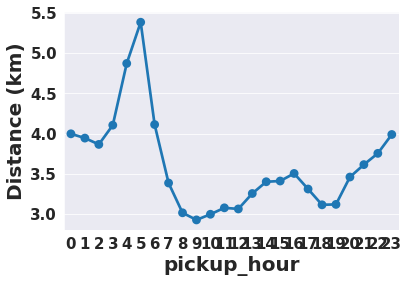

In [ ]:
group5 = df.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

### **Observations**

Trip distance is highest during early morning hours which can account for some things like:
Outstation trips taken during the weekends.
Longer trips towards the city airport which is located in the outskirts of the city.

Trip distance is fairly equal from morning till the evening varying around 3 - 3.5 kms.

It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

### **Distance per weekdays**

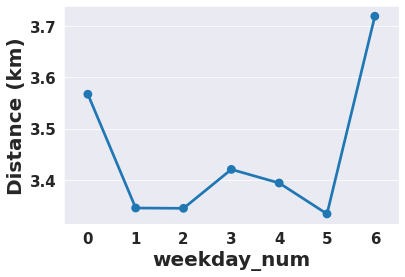

In [ ]:
group6 = df.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

### **Avarage speed per hour**

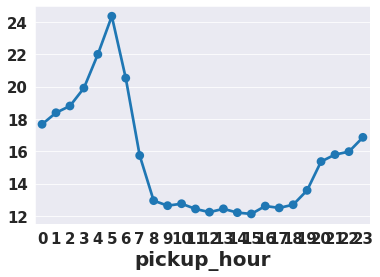

In [ ]:
# Let's look at the average speed of NYC Taxi per hour
group = df.groupby('pickup_hour').speed.mean()
sns.pointplot(group.index, group.values)
plt.show()

### **Observation**


*   The average trend is totally inline with the normal circumstances.
*   Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
*   Average taxi speed is highest at 5 AM in the morning, then it declines steeply as the office hours approaches.
*   Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening.

### **Average speed per weekday**
Let's visualize that on an average what is the speed of a taxi on any given weekday.

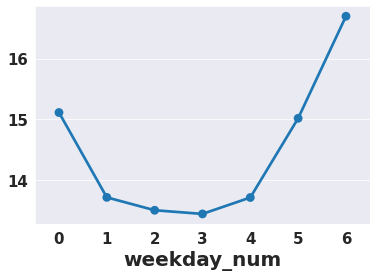

In [ ]:
group10 = df.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

### **Observations**


*   Average taxi speed is higher on weekend as compared to the weekdays which is obvious when there is mostly rush of office goers and business owners.
*   Even on monday the average taxi speed is shown higher which is quite surprising when it is one of the most busiest day after the weekend. There can be several possibility for such behaviour
      1.   Lot of customers who come back from outstation in early hours of Monday before 6 AM to attend office on time.
      2.   Early morning hours customers who come from the airports after vacation to attend office/business on time for the coming week.
*   There could be some more reasons as well which only a local must be aware of.
We also can't deny the anomalies in the dataset. which is quite cumbersome to spot in such a large dataset.







# **Feature Selection**

In [ ]:
#First check the index of the features and label
list(zip( range(0,len(df.columns)),df.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'weekday_num_1'),
 (25, 'weekday_num_2'),
 (26, 'weekday_num_3'),
 (27, 'weekday_num_4'),
 (28, 'weekday_num_5'),
 (29, 'weekday_num_6'),
 (30, 'pickup_hour_1'),
 (31, 'pickup_hour_2'),
 (32, 'pickup_hour_3'),
 (33, 'pickup_hour_4'),
 (34, 'pickup_hour_5'),
 (35, 'pickup_hour_6'),
 (36, 'pickup_hour_7'),
 (37, 'pickup_hour_8'),
 (38, 'pickup_hour_9'),
 (39, 'pickup_hour_10'),
 (40, 'pickup_hour_11'),
 (41, 'pickup_hour_12'),
 (42, 'pickup_hour_13'),
 (43, 'pickup_hour_14'),
 (44, 'pic

In [ ]:
Y = df.iloc[:,10].values
X = df.iloc[:,range(15,61)].values

In [ ]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1458644 rows of 1's as the first column in the X array


In [ ]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [ ]:
X1.shape

(1458644, 47)

In [ ]:
# X_opt = X1[:,[0,1,3,4,6,7,8,9,10,11]]
# regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
# regressor_OLS.summary()

In [ ]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("====================================================================\n")
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()    

Probability values of each feature 

[1.10746936e-002 0.00000000e+000 0.00000000e+000 9.68103956e-001
 3.90406640e-108 7.63656654e-001 9.62608418e-001 2.61814546e-001
 1.21237518e-002 1.05183138e-003 7.14565444e-007 2.45758471e-005
 9.83647608e-008 2.26966030e-007 3.76503049e-007 2.68811164e-001
 9.85903377e-001 6.81711561e-001 7.70603578e-001 6.28604631e-001
 3.52248313e-003 5.01291190e-002 5.57667656e-002 6.91375063e-001
 3.74768701e-001 5.46116266e-001 3.29409236e-001 6.87999006e-002
 2.05262772e-002 5.42883549e-003 3.84379671e-005 7.33794379e-003
 4.71587624e-002 1.08410327e-001 5.38780849e-001 2.00133738e-001
 1.62760871e-001 1.20566049e-002 1.79415669e-001 1.00649017e-001
 1.03696763e-001 1.12146123e-001 1.17022752e-001 1.05590029e-001
 1.06330173e-001 5.20846372e-001]


Feature at index 16 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[1.10641307e-002 0.00000000e+000 0.00000000e+000 9.68093143e-001
 3.89440588e-108 7.63618842e-001 9.62580641

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1005.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:02:44   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458621   BIC:                         2.910e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        642.2426     12.041     53.338      0.000     618.643     665.843
x1           164.8220      1.148    143.630      0.000     162.573     167.071
x2           -28.9725      0.332    -87.332      0.000     -29.623     -28.322
x3           203.8606      8.631     23.621      0.000     186.945     220.776
x4            32.1097     11.697      2.745      0.006       9.184      55.035
x5            44.0644     11.974      3.680      0.000      20.596      67.533
x6            73.9658     14.315      5.167      0.000      45.909     102.022
x7            60.7654     14.167      4.289      0.000      32.998      88.533
x8            78.0896     13.997      5.579      0.000      50.655     105.524
x9            75.0618     13.885      5.406      0.000      47.848     102.276
x10           74.1684     13.917      5.329      0.000      46.892     101.445
x11         -168.7635     43.032     -3.922      0.000    -253.105     -84.422
x12         -101.6475     29.312     -3.468      0.001    -159.099     -44.196
x13          -91.0567     23.014     -3.957      0.000    -136.163     -45.950
x14           40.8467     20.470      1.995      0.046       0.725      80.968
x15           53.9859     20.123      2.683      0.007      14.546      93.426
x16           94.3189     20.434      4.616      0.000      54.270     134.368
x17           53.6104     21.478      2.496      0.013      11.515      95.706
x18          -46.0098     18.444     -2.495      0.013     -82.159      -9.861
x19          -65.3320     19.044     -3.431      0.001    -102.658     -28.006
x20          -68.4386     19.038     -3.595      0.000    -105.753     -31.124
x21           45.2142     19.424      2.328      0.020       7.144      83.285
x22          -67.7949     20.730     -3.270      0.001    -108.425     -27.165
================================================================================
Omnibus:                  8330196.946   Durbin-Watson:                     2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2368102451061102.500
Skew:                         350.196   Prob(JB):                           0.00
Kurtosis:                  197394.513   Cond. No.                           213.
================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Split Data**

In [ ]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

### **Feature Extraction**

In [ ]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

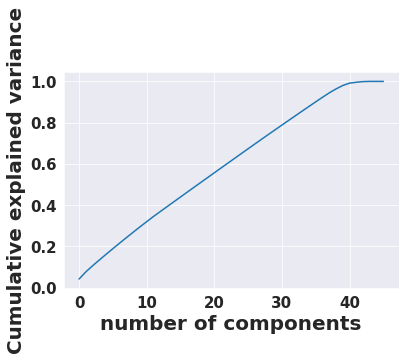

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.21),
 (2, 7.68),
 (3, 10.65),
 (4, 13.450000000000001),
 (5, 16.220000000000002),
 (6, 18.94),
 (7, 21.630000000000003),
 (8, 24.290000000000003),
 (9, 26.900000000000002),
 (10, 29.500000000000004),
 (11, 32.02),
 (12, 34.53),
 (13, 36.9),
 (14, 39.269999999999996),
 (15, 41.629999999999995),
 (16, 43.989999999999995),
 (17, 46.339999999999996),
 (18, 48.69),
 (19, 51.03),
 (20, 53.370000000000005),
 (21, 55.71000000000001),
 (22, 58.05000000000001),
 (23, 60.38000000000001),
 (24, 62.71000000000001),
 (25, 65.04),
 (26, 67.36),
 (27, 69.67999999999999),
 (28, 71.99),
 (29, 74.28999999999999),
 (30, 76.57),
 (31, 78.85),
 (32, 81.11999999999999),
 (33, 83.38),
 (34, 85.64),
 (35, 87.89),
 (36, 90.11),
 (37, 92.32),
 (38, 94.47),
 (39, 96.37),
 (40, 98.04),
 (41, 99.17),
 (42, 99.59),
 (43, 99.92),
 (44, 100.0),
 (45, 100.0)]

In [ ]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

## **Heatmap**

### **On feature selection Data**

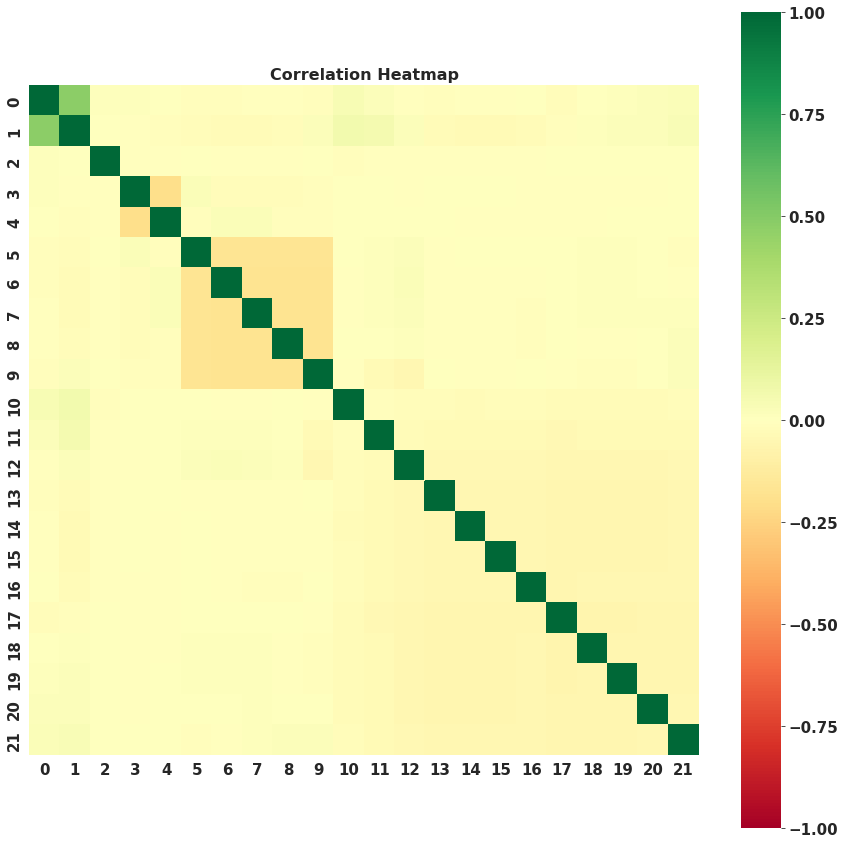

In [ ]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### **Observations**

Finally we have reached the combination of optimum features with each feature having p value < 0.05.

### **On feature extraction Data**

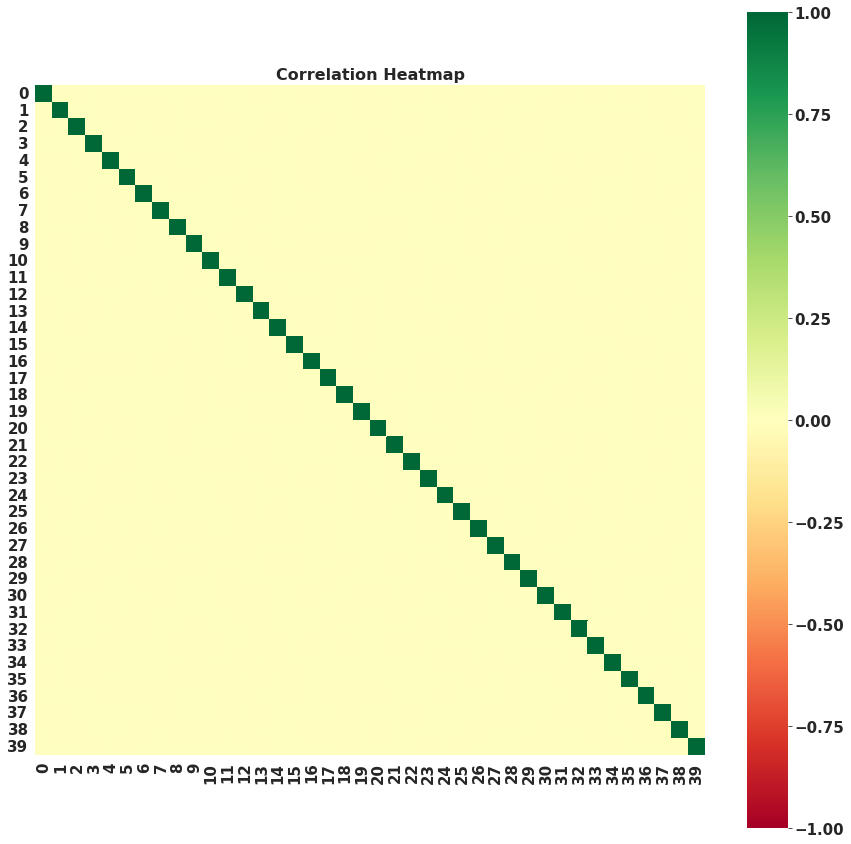

In [ ]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### **Observations**

All of the features shows NO correlation at all. Because feature extraction removes all collinearity.

# **Linear Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [ ]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 

LinearRegression()

In [ ]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [ ]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 4923.025569760419
Variance score for the Multiple LR raw is : 0.02


RMSE score for the Multiple LR FS is : 4923.025569760419
Variance score for the Multiple LR FS is : 0.02


RMSE score for the Multiple LR PCA is : 4957.8020637713535
Variance score for the Multiple LR PCA is : 0.00


In [ ]:
X_train.shape

(1166915, 46)

In [ ]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 46,0.092749
3 vs 46,0.019978
1 vs 46,-0.017008
38 vs 46,-0.008295
29 vs 46,0.006559
28 vs 46,0.005548
42 vs 46,0.005102
30 vs 46,0.004830
21 vs 46,-0.004687
14 vs 46,-0.004470


### **Observations**

We can see that none of the feature is linearly correlated with the target variable "46". That is why it is not a good model for the prediction of the trip duration. So let's move ahead and try the random forest regressor. We are not using decision tree regressor because the random forest will anyways consist of almost all its properties. Also, we will not use SVR because it takes too much time to train on this huge dataset even with the default settings. It seems to be not good with high dimensional dataset as well as for the huge instances.

## **Random Forest Regressor**

In [ ]:
#import the packages
from sklearn.ensemble import RandomForestRegressor
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()

rf_model.fit(X_train_fs,y_train_fs)

In [ ]:
# Making predictions on train and test data

y_pred_train_r = rf_model.predict(X_train_fs)
y_pred_test_r = rf_model.predict(X_test_fs)

### **For train data**

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",rf_model.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_r)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_r))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

Model Score: 0.9627233035525813
MSE : 946912.4220271672
RMSE : 973.0942513586067
MAE : 4.800507577689049
R2 : 0.9627233035525813
Adjusted R2 : 0.9627217037325101


### **For test data**

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_r)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_r)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_r))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_r)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 25468037.98471288
RMSE : 5046.58676579655
MAE : 16.376226808724468
R2 : 0.6344938930322279
Adjusted R2 : 0.6344782064488718


**Interesting find**

There is approx 200% improvement on the RMSE score for the Random forest regressor over the Linear regressor of the feature selection group.

Even the variance score is approx 1 which is a good score.

RMSE score for the RF regressor of feature extraction group is still very bad along with the variance score.

RMSE score for the feature selection group is more or less same as the raw data score. 
Sometimes the RMSE score for the raw data is better and vice versa.
It fluctuates on every iteration and this is quite weird!
Let's see if we can improve this further with the most sought after algorigthm i.e. XGBoost!!

# **XGBoost**

In [ ]:
from xgboost import XGBRegressor
regressor_xgbraw = XGBRegressor(n_jobs=-1)
#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

In [ ]:
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)
#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

[10:03:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [ ]:
# Making predictions on train and test data

y_pred_train_x = regressor_xgb.predict(X_train_fs)
y_pred_test_x = regressor_xgb.predict(X_test_fs)

# For Train Data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_train_fs,y_train_fs))

#calculate MSE
MSE_rf= mean_squared_error(y_train_fs, y_pred_train_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_train_fs, y_pred_train_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score(y_train_fs, y_pred_train_x)
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_x))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )


Model Score: 0.9848624019219396
MSE : 425574.3598247585
RMSE : 652.3606056658836
MAE : 62.32962075377837
R2 : 0.9848624019219396
Adjusted R2 : 0.9848612083710722


# For Test Data

In [ ]:
#import the packages
from sklearn.metrics import mean_squared_error
print("Model Score:",regressor_xgb.score(X_test_fs,y_test_fs))
#calculate MSE
MSE_rf= mean_squared_error(y_test_fs, y_pred_test_x)
print("MSE :",MSE_rf)

#calculate RMSE
RMSE_rf=np.sqrt(MSE_rf)
print("RMSE :",RMSE_rf)


#calculate MAE
MAE_rf= mean_absolute_error(y_test_fs, y_pred_test_x)
print("MAE :",MAE_rf)


#import the packages
from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_rf= r2_score((y_test_fs), (y_pred_test_x))
print("R2 :",r2_rf)
Adjusted_R2_rf=(1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score((y_test_fs), (y_pred_test_x)))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

Model Score: 0.9736287209680698
MSE : 651329.3099000739
RMSE : 807.049756768487
MAE : 64.07043887605909
R2 : 0.9736287209680698
Adjusted R2 : 0.97362664167763




1.   As we can see here we have restricted ourselves on Feature Selection dataset only. The reason behind this is that if here the dimension increases, the time complexity also increases manyfold. So, better to check for the optimal features. Same thinking was behind the operation on Random Forest Regressr
2.   Second observation is that it works exceptionally well for both Training  and Test dataset.



## **Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

ridge1= Ridge(alpha=0.1)
ridge2= Ridge(alpha=0.1)
ridge3= Ridge(alpha=0.1)

In [ ]:
#FIT THE MODEL
ridge1.fit(X_train,y_train)
# Create the model score
print(ridge1.score(X_test, y_test), ridge1.score(X_train, y_train))

0.006189150456451187 0.0191805729473028


In [ ]:
# Fit the Ridge model on Feature Selection data
ridge2.fit(X_train_fs,y_train_fs)
# Create the model score
print(ridge2.score(X_test_fs,y_test_fs), ridge2.score(X_train_fs,y_train_fs))

0.006196528401387513 0.01912850032069957


In [ ]:
# Fit the Ridge model on Feature Extraction data
ridge3.fit(X_train_pca,y_train_pca)
# Create the model score
print(ridge3.score(X_test_pca,y_test_pca), ridge3.score(X_train_pca,y_train_pca))

0.001065880797477936 0.00328101494060018


### **Model Prediction**
**Feature selection based**



**Train Data**

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_fs=ridge2.predict(X_train_fs)
y_pred_test_ridge_fs=ridge2.predict(X_test_fs)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train_fs), (y_pred_train_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train_fs, y_pred_train_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train_fs, y_pred_train_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 24916355.148822818
RMSE : 4991.628506692262
MAE : 364.6812006163739
R2 : 0.01912850032069957
Adjusted R2 : 0.019086403835174126


**Test Data**

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test_fs), (y_pred_test_ridge_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test_fs, y_pred_test_ridge_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train_fs, y_pred_train_ridge_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test_fs, y_pred_test_ridge_fs))*((X_test_fs.shape[0]-1)/(X_test_fs.shape[0]-X_test_fs.shape[1]-1)) )

MSE : 69247063.40472905
RMSE : 8321.482043766546
MAE : 378.296536367151
R2 : 0.01912850032069957
Adjusted R2 : 0.006153876908841394


### **Feature Extraction Based**

**Train Data**

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_ridge_pca=ridge3.predict(X_train_pca)
y_pred_test_ridge_pca=ridge3.predict(X_test_pca)

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_ridge_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_ridge_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_ridge_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_ridge_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 69604560.92822206
RMSE : 8342.934791080537
MAE : 577.3878694056875
R2 : 0.00328101494060018
Adjusted R2 : 0.0008467201745725461





1.   For RIDGE regression, the time complexity is very less. So it enables us to explore it for optimal featues, as well as on the extended features too.
2.   However, it seems that for both dataset the result is very poor. So for this large data RIDGE regression prooves to be futile.



## **Lasso Regression**

In [ ]:
# Create an instance of Lasso Regression implementation
from sklearn.linear_model import Lasso
lasso1 = Lasso(alpha=0.1, max_iter=3000)
lasso2 = Lasso(alpha=0.1, max_iter=3000)
lasso3 = Lasso(alpha=0.1, max_iter=3000)

In [ ]:
# Fit the Lasso model on raw data
lasso1.fit(X_train, y_train)
# Create the model score
print(lasso1.score(X_test, y_test), lasso1.score(X_train, y_train))

0.006195072197483609 0.019179381350149738


In [ ]:
# Fit the Lasso model on Feature Selection data
lasso2.fit(X_train_fs,y_train_fs)
# Create the model score
print(lasso2.score(X_test_fs,y_test_fs), lasso2.score(X_train_fs,y_train_fs))

0.006195634048517973 0.019128466514946485


In [ ]:
# Fit the Lasso model on Feature Extraction data
lasso3.fit(X_train_pca,y_train_pca)
# Create the model score
print(lasso3.score(X_test_pca,y_test_pca), lasso3.score(X_train_pca,y_train_pca))

0.0010662830844346827 0.003281000422185043


## **Model Prediction**
### **Feature Selection Based**

**Train Data**

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_lasso_fs=lasso2.predict(X_train_fs)
y_pred_test_lasso_fs=lasso2.predict(X_test_fs)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train), (y_pred_train_lasso_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train, y_pred_train_lasso_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train, y_pred_train_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train, y_pred_train_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 24916356.007565424
RMSE : 4991.628592710542
MAE : 364.56058751162817
R2 : 0.019128466514946485
Adjusted R2 : 0.01891326872348409


**Test Data**

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_lasso_fs))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_lasso_fs)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_fs)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_lasso_fs))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 69247125.72219084
RMSE : 8321.485788138489
MAE : 378.18086641395155
R2 : 0.019128466514946485
Adjusted R2 : 0.0059775988651147305


### **Feature Extraction Based**

**Train Data**

In [ ]:
#get the X_train and X-test value for Feature Selection
y_pred_train_lasso_pca=lasso3.predict(X_train_pca)
y_pred_test_lasso_pca=lasso3.predict(X_test_pca)

In [ ]:
from sklearn.metrics import mean_squared_error
#calculate MSE
MSE_l= mean_squared_error((y_train), (y_pred_train_lasso_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_train, y_pred_train_lasso_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_train, y_pred_train_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_train, y_pred_train_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 25318917.498551015
RMSE : 5031.790685089257
MAE : 562.8003408381326
R2 : 0.003281000422185043
Adjusted R2 : 0.0030623257842784524


**Test Data**

In [ ]:
#calculate MSE
MSE_l= mean_squared_error((y_test), (y_pred_test_lasso_pca))
print("MSE :",MSE_l)

#calculate RMSE
RMSE_l=np.sqrt(MSE_l)
print("RMSE :",RMSE_l)

#calculate MAE
MAE_l= mean_absolute_error(y_test, y_pred_test_lasso_pca)
print("MAE :",MAE_l)

from sklearn.metrics import r2_score
#calculate r2 and adjusted r2
r2_l= r2_score(y_train, y_pred_train_lasso_pca)
print("R2 :",r2_l)
Adjusted_R2_l = (1-(1-r2_score(y_test, y_pred_test_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )
print("Adjusted R2 :",1-(1-r2_score(y_test, y_pred_test_lasso_pca))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)) )

MSE : 69604532.89733748
RMSE : 8342.933111162853
MAE : 577.3979610797758
R2 : 0.003281000422185043
Adjusted R2 : 0.0008471225497888035


Here the analysis is same as RIDGE Regressor

For Linear, Lasso, and Ridge regressor the model does not works fine. 


1.   As correlation is a linear model, thus we have shown that the all the other featues (in Linear regression) have a very poor correlation with feature no 46. Here we are using correlation, as because it cathches the linear dependency
2.   For the other two regression, we have to catch the non-linear dependency among features. As Mutual Information is an excellent tool to explore non linear dependcy, thus someone can look forward to implement it in order to explore the poor result.



# **CONCLUSION**

During the time of our analysis, we did EDA on all the features of our datset. We first did a bit of data inspection, followed by various Univariate and Multivariate analysis. Those analysis have unveiled some interesting insight about the data, which we have listed in the corresponding places.

Next we have extracted some important featues from the raw dataset. The idea is to check the redundant featues and get rid of it (if required).

Finally we implemented 5 machine learning algorithms: Linear Regression,Lasso, Rdge, Random Forest and XGBoost. We did hyperparameter tuning to improve our model performance. Now in order to avoid unnecesssary time complexity we have considered Feature Seleceted dataset for Random Forest, and XGBoost. 

While compairing the results we have found that for XGBoost the results are very well, followed by Random Forest. However for the remianing three ML algorithms the results are very poor. The possible reason behind this is also partially explored by menas of correlation. In future one can elaborate the non linear dependency result using Mutual Information or by any other tool.